In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh

# QUESTION 3 Kernel vs linear Ridge Regression

### Data Generation 

<class 'numpy.ndarray'>
100


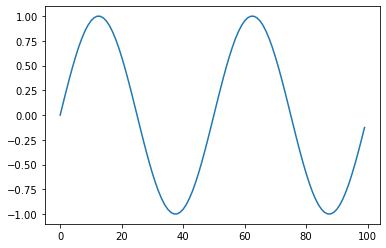

In [2]:
cycles = 2 # how many sine cycles
resolution = 100 # how many datapoints to generate

length = np.pi * 2 * cycles
sine_wave = np.sin(np.arange(0, length, length / resolution))
print(type(sine_wave))
print(sine_wave.size)
plt.plot(sine_wave)

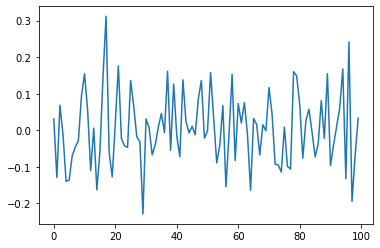

In [3]:
noise = np.random.normal(0,0.1,100)
plt.plot(noise)

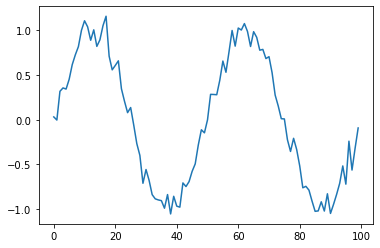

In [4]:
sine_wave2 = sine_wave + noise
plt.plot(sine_wave2)

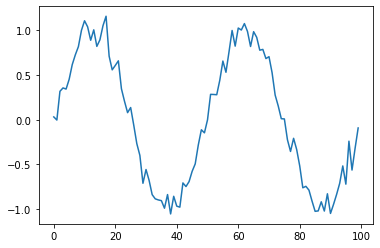

In [5]:
x = np.arange(0,100)
y = sine_wave2
plt.plot(x,y)

### Gaussian kernel Matrix

In [6]:
import numexpr as ne
X = x.reshape(-1, 1)
gamma = 0.008
var =1
X_norm = np.sum(X ** 2, axis = -1)
K = ne.evaluate('v * exp(-g * (A + B - 2 * C))', {
        'A' : X_norm[:,None],
        'B' : X_norm[None,:],
        'C' : np.dot(X, X.T),
        'g' : gamma,
        'v' : var
})

### Ridge Regression Class

In [7]:
class RidgeRegScratch():
  # include solver parameter for flexible implementation of gradient descent
  # solution in future, alpha is used in place of lambda to mimic scikit-learn
  def __init__(self, alpha=1.0, solver='closed'):
      self.alpha = alpha
      self.solver = solver

  def fit(self, X, y):
      X_with_intercept = np.c_[np.ones((X.shape[0], 1)), X]
      self.X_intercept = X_with_intercept
      if self.solver == 'closed':
          # number of columns in matrix of X including intercept
          dimension = X_with_intercept.shape[1]
          # Identity matrix of dimension compatible with our X_intercept Matrix
          A = np.identity(dimension)
          A[0, 0] = 0
          A_biased = self.alpha * A
          thetas = np.linalg.inv(X_with_intercept.T.dot(X_with_intercept) + A_biased).dot(X_with_intercept.T).dot(y)
      self.thetas = thetas
      return self

  def predict(self, X):
      thetas = self.thetas
      X_predictor= np.c_[np.ones((X.shape[0], 1)), X]
      self.predictions = X_predictor.dot(thetas)
      return self.predictions

### Linear Ridge Regression

Text(0, 0.5, 'dependent variable/target : y')

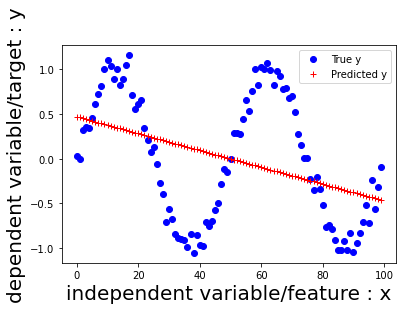

In [8]:
ridge = RidgeRegScratch()
ridge.fit(X, y)
y_pred = ridge.predict(X)
plt.plot(x,y, 'bo', label ='True y')
plt.plot(x,y_pred, 'r+',label ='Predicted y')
plt.legend()
plt.xlabel('independent variable/feature : x',fontsize=20)
plt.ylabel('dependent variable/target : y',fontsize=20)

### Gaussian Kernel Ridge Regression

Text(0, 0.5, 'dependent variable/target : y')

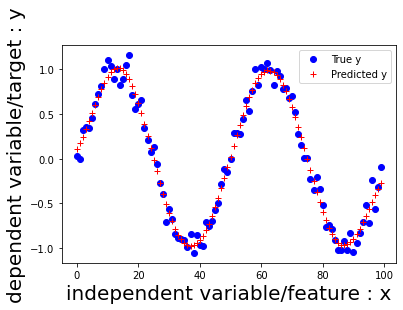

In [9]:
ridge = RidgeRegScratch()
ridge.fit(K, y)# using Gaussian Kernel Matrix K instead of X
y_pred = ridge.predict(K)
plt.plot(x,y, 'bo', label ='True y')
plt.plot(x,y_pred, 'r+',label ='Predicted y')
plt.legend()
plt.xlabel('independent variable/feature : x',fontsize=20)
plt.ylabel('dependent variable/target : y',fontsize=20)

Gaussian Kernel Ridge Regression is fitting the sinusoidal data perfectly.

# QUESTION 4 - Kernel PCA vs Linear PCA

In [10]:
 
def my_pca_custom(X, gamma, n_components, type ='rbf'):
    """
    PCA function that can do either LINEAR or RBF Kernel PCA.  
    Parameters
    ------------
    X: {NumPy ndarray}, shape = [n_examples, n_features]  
    gamma: float
        Tuning parameter of the RBF kernel    
    n_components: int
        Number of principal components to return   
    type : string
        options - 'rbf' or 'linear'
    Returns
    ------------
    X_pc: {NumPy ndarray}, shape = [n_examples, k_features]
        Projected dataset   
    """
    # Calculate pairwise squared Euclidean distances
    # in the MxN dimensional dataset.
    if type =='rbf':
        sq_dists = pdist(X, 'sqeuclidean')    
        # Convert pairwise distances into a square matrix.
        mat_sq_dists = squareform(sq_dists)    
        # Compute the symmetric kernel matrix.
        K = exp(-gamma * mat_sq_dists)    
        # Center the kernel matrix.
        N = K.shape[0]
        one_n = np.ones((N,N)) / N
        K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)    
        # Obtaining eigenpairs from the centered kernel matrix
        # scipy.linalg.eigh returns them in ascending order
        eigvals, eigvecs = eigh(K)
    elif type == 'linear': 
        eigvals, eigvecs = eigh(np.dot(X,X.transpose()))
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]    
    # Collect the top k eigenvectors (projected examples)
    X_pc = np.column_stack([eigvecs[:, i]
                           for i in range(n_components)])    
    return X_pc

# Linearly Non Separable data generation

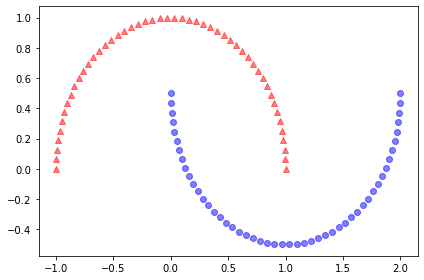

In [11]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, random_state=123)
plt.scatter(X[y==0, 0], X[y==0, 1],
color='red', marker='^', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1],
color='blue', marker='o', alpha=0.5)
plt.tight_layout()
plt.show()

# Plots from vanilla PCA

In [12]:
def plot_pca(X_spca, type_pca = 'linear'):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,3))
    ax[0].scatter(X_spca[y==0, 0], X_spca[y==0, 1],color='red', marker='^', alpha=0.5)
    ax[0].scatter(X_spca[y==1, 0], X_spca[y==1, 1],color='blue', marker='o', alpha=0.5)
    ax[1].scatter(X_spca[y==0, 0], np.zeros((50,1))+0.02,color='red', marker='^', alpha=0.5)
    ax[1].scatter(X_spca[y==1, 0], np.zeros((50,1))-0.02, color='blue', marker='o', alpha=0.5)
    ax[0].set_xlabel('PC1')
    ax[0].set_ylabel('PC2')
    ax[1].set_ylim([-1, 1])
    ax[1].set_yticks([])
    ax[1].set_xlabel('PC1')
    plt.tight_layout()
    plt.title(type_pca+' PCA plot')
    plt.show()

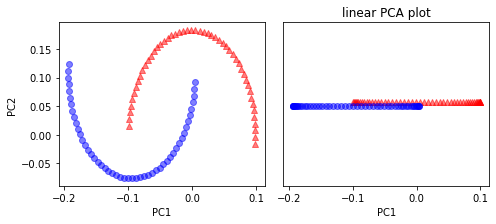

In [13]:
X_kpca = my_pca_custom(X, gamma=15, n_components=2, type ='linear')
plot_pca(X_kpca, 'linear')

### Comments on the results from vanilla PCA

# Plots from Kernel PCA

<ipython-input-10-88e742457c36>:25: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  K = exp(-gamma * mat_sq_dists)


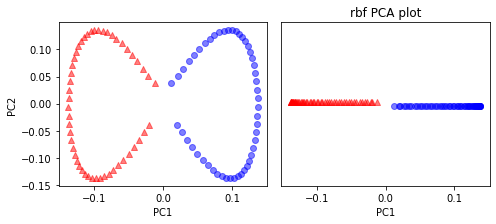

In [14]:
X_kpca = my_pca_custom(X, gamma=15, n_components=2, type ='rbf')
plot_pca(X_kpca, 'rbf')

### Comments on the performance of Kernel PCA